# based on [TFP Probabilistic Layers VAE](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

import extended_tfp as extfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

tf.keras.backend.set_image_data_format('channels_first')

# Data

In [2]:
datasets, datasets_info = tfds.load(name='mnist', with_info=True, as_supervised=False)

W1008 17:54:01.197091 140541645518656 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [3]:
def preprocess_mnist(sample):
    # Scale to unit interval.
    image = tf.cast(sample['image'], tf.float32) / 255.
    # NHWC to NCHW
    image = tf.transpose(image, (2, 0, 1))
    
    # Randomly binarize.
    # image = image < tf.random.uniform(tf.shape(image))
    
    input_image = tf.cast(image, tf.float32)
    label_image = tf.cast(image, tf.int64)
    return input_image, image


train_dataset = (datasets['train']
                 .map(preprocess_mnist)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))

eval_dataset = (datasets['test']
                .map(preprocess_mnist)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))

In [74]:
def build_model(input_shape, encoded_size=16, base_depth=32):
    prior = tfd.Independent(
        tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
        reinterpreted_batch_ndims=1)

    # posterior
    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=input_shape),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=tf.nn.leaky_relu),
        # tfkl.Flatten(),
        tfkl.GlobalAveragePooling2D(),
        tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
                   activation=None),
        tfpl.MultivariateNormalTriL(
            encoded_size,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
    ])
    
    # likelihood
    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[encoded_size]),
        tfkl.Reshape([encoded_size, 1, 1]),
        tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                             padding='valid', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                    padding='same', activation=None),
        tfkl.Flatten(),
        tfpl.IndependentBernoulli(
            event_shape=input_shape,
            convert_to_tensor_fn=tfd.Bernoulli.logits),
    ])
    
    vae = tfk.Model(
        inputs=encoder.inputs,
        outputs=decoder(encoder.outputs[0]))
    
    return vae, encoder, decoder, prior

In [75]:
vae, encoder, decoder, prior = build_model(input_shape=train_dataset.output_shapes[0][1:])

In [78]:
encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 28, 28)        832       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 14, 14)        25632     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 14, 14)        51264     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 7, 7)          102464    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 1, 1)          200768    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 152)              

In [80]:
decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 16, 1, 1)          0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 64, 7, 7)          50240     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 64, 7, 7)          102464    
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 64, 14, 14)        102464    
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 32, 14, 14)        51232     
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 32, 28, 28)        25632     
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 32, 28, 28)       

In [81]:
vae.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
    loss=extfp.losses.negative_log_likelihood)

In [82]:
history = vae.fit(train_dataset, epochs=15, validation_data=eval_dataset)

Epoch 1/15
235/235 [==============================] - 15s 66ms/step - loss: 241.5700 - val_loss: 0.0000e+00
Epoch 2/15
235/235 [==============================] - 14s 59ms/step - loss: 161.8964 - val_loss: 147.3864
Epoch 3/15
235/235 [==============================] - 13s 57ms/step - loss: 143.9048 - val_loss: 138.4174
Epoch 4/15
235/235 [==============================] - 14s 58ms/step - loss: 136.9084 - val_loss: 133.3128
Epoch 5/15
235/235 [==============================] - 14s 59ms/step - loss: 132.3885 - val_loss: 128.9786
Epoch 6/15
235/235 [==============================] - 14s 58ms/step - loss: 128.5611 - val_loss: 126.5974
Epoch 7/15
235/235 [==============================] - 14s 59ms/step - loss: 126.4536 - val_loss: 125.3480
Epoch 8/15
235/235 [==============================] - 14s 58ms/step - loss: 124.8457 - val_loss: 123.1943
Epoch 9/15
235/235 [==============================] - 14s 59ms/step - loss: 123.3770 - val_loss: 123.0984
Epoch 10/15
235/235 [=======================

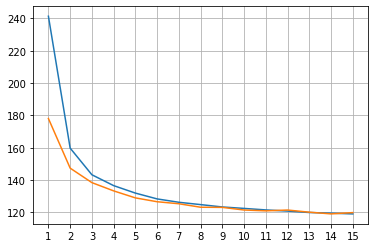

In [84]:
loss = history.history['loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss)
plt.plot(epoch, history.history['val_loss'])

_ = plt.xticks(epoch)
plt.grid()

# Visualize

In [94]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

In [95]:
def display_imgs(x, title=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    n = x.shape[0]
    fig, axarr = plt.subplots(1, n, figsize=(n, 1))
    
    if title is not None:
        fig.suptitle(title, y=1.05)
    
    for i in range(n):
        axarr.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
        axarr.flat[i].axis('off')

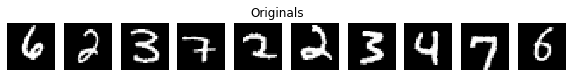

In [96]:
display_imgs(x, 'Originals')

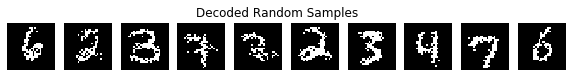

In [97]:
display_imgs(xhat.sample(), 'Decoded Random Samples')

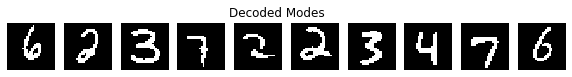

In [98]:
display_imgs(xhat.mode(), 'Decoded Modes')

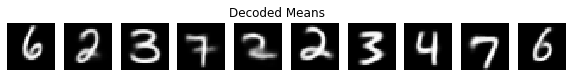

In [99]:
display_imgs(xhat.mean(), 'Decoded Means')

# Check mode collapse

# Anomalous Data

In [100]:
fashion_mnist = tfds.load('fashion_mnist', split='test')
emnist_letters = tfds.load('emnist/letters', split='test')

In [101]:
def preprocess_fashion_mnist(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.
    image = tf.transpose(image, (2, 0, 1))
    # image = image < tf.random.uniform(tf.shape(image))
    # image = tf.cast(image, tf.float32) - 0.5
    return image

In [102]:
def preprocess_emnist(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.
    image = tf.transpose(image, (2, 0, 1))
    image = tf.transpose(image, (0, 2, 1))
    # image = image < tf.random.uniform(tf.shape(image))
    # image = tf.cast(image, tf.float32) - 0.5
    return image

In [103]:
fashion_mnist = (fashion_mnist
                 .map(preprocess_fashion_mnist)
                 .batch(64)
                 .prefetch(tf.data.experimental.AUTOTUNE))

In [104]:
emnist_letters = (emnist_letters
                .map(preprocess_emnist)
                .batch(64)
                .prefetch(tf.data.experimental.AUTOTUNE)).shuffle(int(1e3))

In [105]:
def show_images(images, title=None, figsize=(4, 4)):
    if isinstance(images, tf.Tensor):
        images = images.numpy()
    images = images.squeeze()
    fig, axarr = plt.subplots(figsize=figsize, ncols=figsize[0], nrows=figsize[1])
    for ax, img in zip(axarr.flatten(), images):
        ax.imshow(img, cmap=plt.cm.gray)
        ax.axis('off')
    if title is not None:
        fig.suptitle(title, y=1)

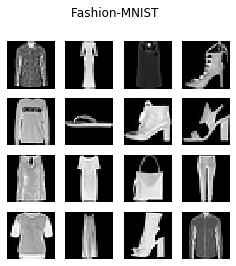

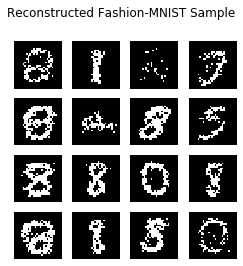

In [106]:
x_fashion = next(tfds.as_numpy(fashion_mnist))
x_fashion_dist = vae(x_fashion)

show_images(x_fashion, title='Fashion-MNIST')
show_images(x_fashion_dist.sample(), title='Reconstructed Fashion-MNIST Sample')

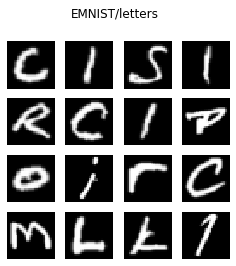

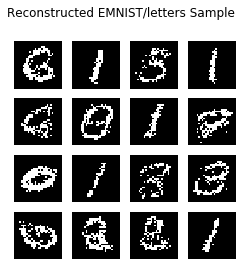

In [107]:
x_letters = next(tfds.as_numpy(emnist_letters))
x_letters_dist = vae(x_letters)

show_images(x_letters, title='EMNIST/letters')
show_images(x_letters_dist.sample(), title='Reconstructed EMNIST/letters Sample')

In [108]:
vae.predict?

In [48]:
class GenerativeModel(tfk.Model):

    def __init__(self, prior, likelihood):
        super(GenerativeModel, self).__init__(name='generative_model')
        self.prior = prior
        self.likelihood = likelihood

    def call(self, inputs=None):
        return self.likelihood(self.prior.sample(1))

generative_model = GenerativeModel(prior, decoder)